In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [52]:
torch.manual_seed(42)
np.random.seed(42)
num_samples = 100
input_dim = 10
output_dim = 1

X = torch.sin(torch.randn(num_samples, input_dim))
noise = torch.randn(num_samples, output_dim) * 0.1
weights_true = torch.randn(input_dim, output_dim)
y = torch.matmul(X, weights_true) + noise

In [53]:
hidden_width = min(input_dim, output_dim)

class LinearNN(nn.Module):
    def __init__(self, num_hidden_layers, std,
                 input_dim=input_dim, hidden_width=hidden_width, output_dim=output_dim):
        super(LinearNN, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_dim, hidden_width, bias=False))
        for l in range(num_hidden_layers-1): # Depth
            self.model.add_module(f"linear{l}", nn.Linear(hidden_width, hidden_width, bias=False))
        self.model.add_module("output", nn.Linear(hidden_width, output_dim, bias=False))
        self._initialize_weights_uniform(std)

    def forward(self, x):
        return self.model(x)

    def _initialize_weights_uniform(self, std):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.uniform_(module.weight, a=-std, b=std)

In [54]:
learning_rate = 0.01
num_iterations = 500
objective_values = [[] for _ in range(3)]
gradient_magnitudes = [[] for _ in range(3)]
max_eigenvalues = [[] for _ in range(3)]
min_eigenvalues = [[] for _ in range(3)]

for j, num_hidden_layers in enumerate(range(1, 4)):
    model = LinearNN(num_hidden_layers, 0.5)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for i in range(num_iterations):
        # Compute loss
        predictions = model(X)
        loss = criterion(y, predictions)
        objective_values[j].append(loss.item())

        # Backprop. step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute gradient magnitude
        gradients = []
        for param in model.parameters():
            gradients.append(param.grad.view(-1))
        gradient_magnitude = torch.norm(torch.cat(gradients))
        gradient_magnitudes[j].append(gradient_magnitude.item())

        # Compute maximal and minimal eigenvalues of the hessian
        # Simulating net output given weights
        def simulate_net(w_inputs):
            res = X # Incremented result
            start_idx = 0 # Start index of current parameters
            for p in model.parameters():
                end_idx = start_idx + p.detach().view(-1).shape[0] # End index of current parameters
                w = w_inputs[start_idx:end_idx].view(p.shape).t() # Relevant parameters
                res = res.mm(w) # Increment result
                start_idx = end_idx # Advance start index
            return criterion(y, res)
        w_inputs = torch.cat([p.detach().view(-1) for p in model.parameters()]) # Vectorize parameters
        hessian = F.hessian(simulate_net, w_inputs)
        eigenvalues = torch.linalg.eigh(hessian)[0]
        max_eigenvalues[j].append(torch.max(eigenvalues).item())
        min_eigenvalues[j].append(torch.min(eigenvalues).item())

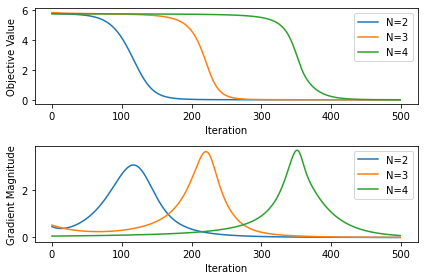

In [55]:
# Plotting the results
plt.figure()

for j, num_hidden_layers in enumerate(range(1, 4)):
    plt.subplot(2, 1, 1)
    plt.plot(range(0, num_iterations), objective_values[j], label=f'N={num_hidden_layers+1}')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(range(0, num_iterations), gradient_magnitudes[j], label=f'N={num_hidden_layers+1}')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Magnitude')
    plt.legend()

plt.tight_layout()
plt.show()

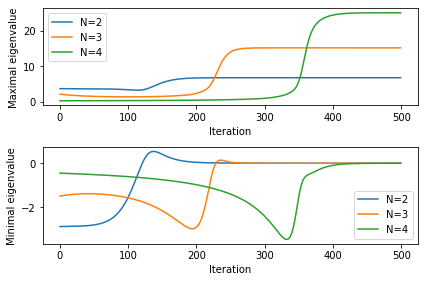

In [56]:
plt.figure()

for j, num_hidden_layers in enumerate(range(1, 4)):
    plt.subplot(2, 1, 1)
    plt.plot(range(0, num_iterations), max_eigenvalues[j], label=f'N={num_hidden_layers+1}')
    plt.xlabel('Iteration')
    plt.ylabel('Maximal eigenvalue')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(range(0, num_iterations), min_eigenvalues[j], label=f'N={num_hidden_layers+1}')
    plt.xlabel('Iteration')
    plt.ylabel('Minimal eigenvalue')
    plt.legend()

plt.tight_layout()
plt.show()

In [57]:
print(min_eigenvalues[1])

[-1.5050297975540161, -1.4988292455673218, -1.492869257926941, -1.4871423244476318, -1.481638789176941, -1.4763542413711548, -1.471281886100769, -1.4664132595062256, -1.4617451429367065, -1.457270860671997, -1.4529844522476196, -1.4488810300827026, -1.4449564218521118, -1.441205620765686, -1.4376240968704224, -1.4342076778411865, -1.4309529066085815, -1.4278554916381836, -1.4249122142791748, -1.4221196174621582, -1.4194738864898682, -1.4169719219207764, -1.414612054824829, -1.4123917818069458, -1.4103057384490967, -1.4083541631698608, -1.4065337181091309, -1.404842495918274, -1.4032766819000244, -1.4018365144729614, -1.400519609451294, -1.3993237018585205, -1.3982470035552979, -1.3972883224487305, -1.396446943283081, -1.3957195281982422, -1.3951066732406616, -1.3946062326431274, -1.394217610359192, -1.393939733505249, -1.3937705755233765, -1.3937113285064697, -1.3937588930130005, -1.3939146995544434, -1.3941757678985596, -1.3945438861846924, -1.395017147064209, -1.395595669746399, -1.3